# Assignment 2 Xi Peng
## Develop RAW images

In [11]:
import glob
import os
import subprocess
import cv2
import numpy as np


In [ ]:
# Get files with .NEF
raw_files = glob.glob(os.path.join("data", "door_stack", "door_stack", "*.nef"))
# print(raw_files)

# loop row and do the dcraw
for file in raw_files:
    command = f"dcraw -v -w -q 3 -o 1 -4 -T \"{file}\""
    print("In processing:", file)
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

In processing: data/door_stack/door_stack/exposure9.nef
In processing: data/door_stack/door_stack/exposure8.nef
In processing: data/door_stack/door_stack/exposure13.nef
In processing: data/door_stack/door_stack/exposure12.nef
In processing: data/door_stack/door_stack/exposure10.nef
In processing: data/door_stack/door_stack/exposure11.nef
In processing: data/door_stack/door_stack/exposure15.nef
In processing: data/door_stack/door_stack/exposure14.nef
In processing: data/door_stack/door_stack/exposure16.nef
In processing: data/door_stack/door_stack/exposure1.nef
In processing: data/door_stack/door_stack/exposure3.nef
In processing: data/door_stack/door_stack/exposure2.nef
In processing: data/door_stack/door_stack/exposure6.nef
In processing: data/door_stack/door_stack/exposure7.nef
In processing: data/door_stack/door_stack/exposure5.nef
In processing: data/door_stack/door_stack/exposure4.nef


## Linearization

In [ ]:

from imageio.v2 import imread
# Get files with .jpg
jpg_files = []
for i in range(1, 17):
    jpg_files.append(os.path.join("data", "door_stack", 
                                  "door_stack", f"exposure{i}.jpg"))
num_images = len(jpg_files)
H, W= cv2.imread(str(jpg_files[0]), cv2.IMREAD_UNCHANGED).shape[:2]
print(jpg_files)
print("Number of images:", num_images)
print("Image size:", H, W)

['data/door_stack/door_stack/exposure1.jpg', 'data/door_stack/door_stack/exposure2.jpg', 'data/door_stack/door_stack/exposure3.jpg', 'data/door_stack/door_stack/exposure4.jpg', 'data/door_stack/door_stack/exposure5.jpg', 'data/door_stack/door_stack/exposure6.jpg', 'data/door_stack/door_stack/exposure7.jpg', 'data/door_stack/door_stack/exposure8.jpg', 'data/door_stack/door_stack/exposure9.jpg', 'data/door_stack/door_stack/exposure10.jpg', 'data/door_stack/door_stack/exposure11.jpg', 'data/door_stack/door_stack/exposure12.jpg', 'data/door_stack/door_stack/exposure13.jpg', 'data/door_stack/door_stack/exposure14.jpg', 'data/door_stack/door_stack/exposure15.jpg', 'data/door_stack/door_stack/exposure16.jpg']
Number of images: 16
Image size: 4000 6000


In [190]:
selected_index = np.random.permutation(H*W)[:200].tolist()
channel = 3
selected_pixels = [
    imread(p)
    .reshape(-1, channel)[selected_index]
    .flatten() for p in jpg_files
]
selected_pixels = np.stack(selected_pixels, axis=0).transpose()
print("Selected pixels shape:", selected_pixels.shape)

Selected pixels shape: (600, 16)


In [191]:
exposure_times = np.arange(1, num_images + 1)
exposure_times = 2 ** (exposure_times - 1)/2048
print("Exposure times:", exposure_times)

Exposure times: [4.8828125e-04 9.7656250e-04 1.9531250e-03 3.9062500e-03 7.8125000e-03
 1.5625000e-02 3.1250000e-02 6.2500000e-02 1.2500000e-01 2.5000000e-01
 5.0000000e-01 1.0000000e+00 2.0000000e+00 4.0000000e+00 8.0000000e+00
 1.6000000e+01]


In [204]:
from typing import Callable
z_min = 0.05
z_max = 0.95
def w_uniform(z, *_):
    return np.where((z >= z_min) & (z <= z_max), 1, 0)

def w_tent(z, *_):
    return np.where((z >= z_min) & (z <= z_max), np.minimum(z, 1 - z), 0)

def w_gaussian(z, *_):
    return np.where((z >= z_min) & (z <= z_max), np.exp(-4 * (z - 0.5)**2 / (0.5**2)), 0)

def w_photon(z, t):
    return np.where((z >= z_min) & (z <= z_max), t, 0)

w_functions = {
    'uniform': w_uniform,
    'tent': w_tent,
    'gaussian': w_gaussian,
    'photon': w_photon
}

def gsolve(Z, B, l, weighting_function: Callable):
    Z = Z.astype(np.int64)
    n = 256
    num_pixels, num_images = Z.shape
    A_rows = num_pixels * num_images + n+1
    A_cols = n + num_pixels

    # 初始化线性方程组 A * x = b
    A = np.zeros((A_rows, A_cols), dtype=np.float32)
    b = np.zeros((A_rows,), dtype=np.float32)

    k = 0
    for i in range(num_pixels):
        for j in range(num_images):
            z_ij = Z[i, j]
            wij = weighting_function(z_ij / 255.0, np.exp(B[j]))
            A[k, z_ij] = wij
            A[k, n + i] = -wij
            b[k] = wij * B[j]
            k += 1

    A[k, 128] = 1
    k += 1

    for i in range(0, n - 2):
        if weighting_function != w_photon:
            w_i = weighting_function((i+1) / 255.0, None)
        else:
            w_i = 1
        A[k, i]     = l * w_i
        A[k, i + 1] = -2 * l * w_i
        A[k, i + 2] = l * w_i
        k += 1

    print(f"Solving system of size A: {A.shape}, b: {b.shape}")
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    g = x[:n]
    lE = x[n:]

    return g, lE

Solving system of size A: (9857, 856), b: (9857,)
(256,) (600,)


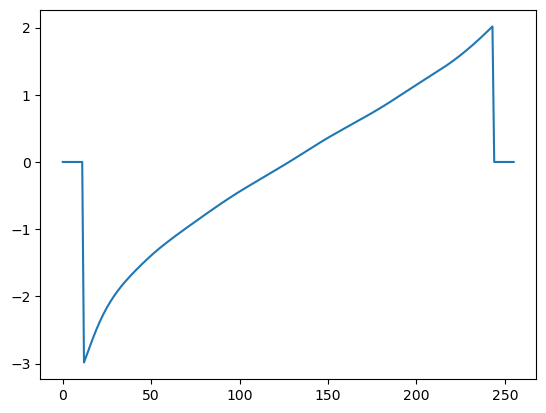

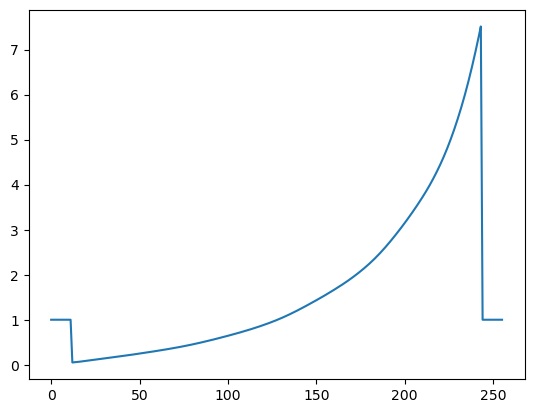

In [205]:

import matplotlib.pyplot as plt
method = 'tent'
lamb = 100

g, lE = gsolve(selected_pixels, np.log(exposure_times), lamb, w_functions[method])
print(g.shape, lE.shape)

plt.plot(range(256), g)
plt.show()
plt.plot(range(256), np.exp(g))
plt.show()

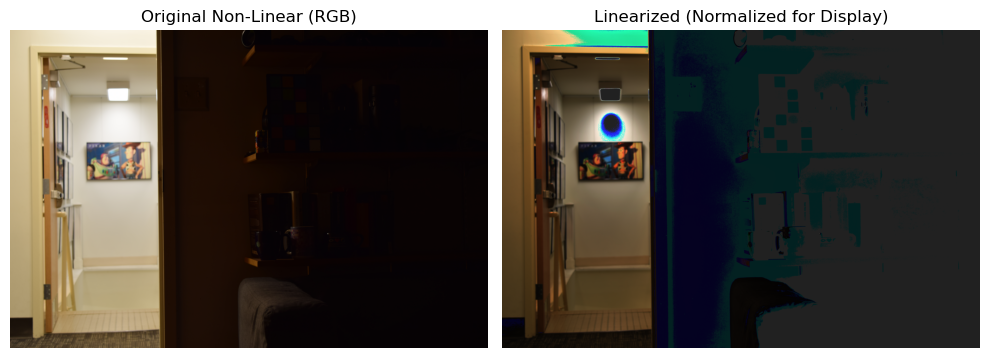

In [206]:
def convert_to_linear_image_rgb(img_nonlin: np.ndarray, g: np.ndarray, norm=False) -> np.ndarray:
    img_nonlin = np.clip(img_nonlin, 0, 255).astype(np.uint16)
    H, W, C = img_nonlin.shape
    img_lin = np.zeros((H, W, C), dtype=np.float32)
    for c in range(C):
        img_lin[..., c] = np.exp(g[img_nonlin[..., c]])
        if norm:
            img_lin[..., c] = img_lin[..., c] / np.max(img_lin[..., c])
    return img_lin

img_test = imread(os.path.join("data", "door_stack", 
                                  "door_stack", "exposure10.jpg"))



img_lin = convert_to_linear_image_rgb(img_test, g, norm=True)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original Non-Linear (RGB)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_lin)
plt.title("Linearized (Normalized for Display)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [210]:
import numpy as np
from imageio.v2 import imread
jpg_files = []
tiff_files = []
for i in range(1, 17):
    jpg_files.append(os.path.join("data", "door_stack", 
                                  "door_stack", f"exposure{i}.jpg"))
    tiff_files.append(os.path.join("data", "door_stack",
                                "door_stack", f"exposure{i}.tiff"))
print(jpg_files)
print(tiff_files)

tiff_images = np.array([imread(f).astype(np.float32) / (2**16  -1)  for f in tiff_files])
print(tiff_images.shape)


jpg_images_ldr = np.array([imread(f).astype(np.float32)/ (2**8  -1) for f in jpg_files])
print(jpg_images_ldr.shape)
print(jpg_images_ldr.max(), jpg_images_ldr.min())
jpg_images_lin = np.array([convert_to_linear_image_rgb(imread(f), g).astype(np.float32) for f in jpg_files])
print(jpg_images_lin.shape)

def merge_hdr(images_ldr, images_lin, times, w_func):
    w_values = w_func(images_ldr)

    numerator = np.sum(
        w_values * (images_lin / times[:, None, None, None]),
        axis=0
    )

    denominator = np.sum(w_values, axis=0)
    hdr_image = np.divide(numerator, denominator, 
                          out=np.zeros_like(numerator), 
                          where=(denominator != 0))

    return hdr_image

def log_merge_hdr(images_ldr, images_lin, times, w_func):

    w_values = w_func(images_ldr)

    numerator = np.sum(
        w_values * (np.log(images_lin + 1e-10) - np.log(times[:, None, None, None])),
        axis=0
    )

    denominator = np.sum(w_values, axis=0)


    hdr_image = np.exp(np.divide(numerator, denominator, 
                          out=np.zeros_like(numerator), 
                          where=(denominator != 0)))

    return hdr_image

hdr_result_tiff = merge_hdr(tiff_images, tiff_images, exposure_times, w_tent)
hdr_result_jpg = merge_hdr(jpg_images_ldr, jpg_images_lin, exposure_times, w_tent)



log_hdr_result_tiff = log_merge_hdr(tiff_images, tiff_images, exposure_times, w_tent)
log_hdr_result_jpg = log_merge_hdr(jpg_images_ldr, jpg_images_lin, exposure_times, w_tent)


def writeHDR(name, data):

    cv2.imwrite(name, data[:, :, ::-1].astype(np.float32))

writeHDR("door_stack_tiff_hdr.hdr", hdr_result_tiff)
writeHDR("door_stack_jpg_hdr.hdr", hdr_result_jpg)

writeHDR("door_stack_tiff_log_hdr.hdr", log_hdr_result_tiff)
writeHDR("door_stack_jpg_log_hdr.hdr", log_hdr_result_jpg)

['data/door_stack/door_stack/exposure1.jpg', 'data/door_stack/door_stack/exposure2.jpg', 'data/door_stack/door_stack/exposure3.jpg', 'data/door_stack/door_stack/exposure4.jpg', 'data/door_stack/door_stack/exposure5.jpg', 'data/door_stack/door_stack/exposure6.jpg', 'data/door_stack/door_stack/exposure7.jpg', 'data/door_stack/door_stack/exposure8.jpg', 'data/door_stack/door_stack/exposure9.jpg', 'data/door_stack/door_stack/exposure10.jpg', 'data/door_stack/door_stack/exposure11.jpg', 'data/door_stack/door_stack/exposure12.jpg', 'data/door_stack/door_stack/exposure13.jpg', 'data/door_stack/door_stack/exposure14.jpg', 'data/door_stack/door_stack/exposure15.jpg', 'data/door_stack/door_stack/exposure16.jpg']
['data/door_stack/door_stack/exposure1.tiff', 'data/door_stack/door_stack/exposure2.tiff', 'data/door_stack/door_stack/exposure3.tiff', 'data/door_stack/door_stack/exposure4.tiff', 'data/door_stack/door_stack/exposure5.tiff', 'data/door_stack/door_stack/exposure6.tiff', 'data/door_stack/

## White Balancing and Color correction

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread
import os
import cv2 # For writeHDR/readHDR if not using cp_exr

# Assuming cp_hw2.py is accessible and contains read_colorchecker_gm
# If not, you might need to add its path or copy the function here.
try:
    from src.cp_hw2 import read_colorchecker_gm
except ImportError:
    print("Warning: Could not import read_colorchecker_gm from src.cp_hw2. Define it manually if needed.")
    # Define a placeholder if necessary
    def read_colorchecker_gm():
        # Placeholder: returns random data matching shape
        print("Using placeholder read_colorchecker_gm")
        return np.random.rand(4, 6), np.random.rand(4, 6), np.random.rand(4, 6)

# Function to write HDR (using cv2 as an alternative if cp_exr/cp_hw2 not set up)
def writeHDR(name, data):
    # Ensure data is float32
    data_float32 = data.astype(np.float32)
    # OpenCV expects BGR, so flip channels if needed (assuming data is RGB)
    cv2.imwrite(name, data_float32[:, :, ::-1])
    print(f"Saved HDR image to: {name}")

def get_patch_coordinates(image_for_coords, patch_coord_file='patch_coords.npy'):
    """
    Interactively gets coordinates for 24 patches using plt.ginput.
    Saves coordinates to a file to avoid repetition.
    Returns coordinates as a list of 24 tuples, each (y_center, x_center).
    """
    if os.path.exists(patch_coord_file):
        print(f"Loading patch coordinates from {patch_coord_file}")
        return np.load(patch_coord_file).tolist()

    print("Please click on the center of each of the 24 color checker patches, starting from 1 (dark skin) to 24 (black).")
    plt.imshow(np.clip(image_for_coords**(1/2.2), 0, 1)) # Display gamma corrected for better visibility
    plt.title("Click center of patches 1-24")
    # ginput returns list of (x, y) tuples
    coords_xy = plt.ginput(24, timeout=-1)
    plt.close()

    if len(coords_xy) != 24:
        raise ValueError("Did not get 24 coordinates. Please try again.")

    # Convert (x, y) to (row, col) i.e., (y, x) and ensure they are integers
    coords_yx = [(int(round(y)), int(round(x))) for x, y in coords_xy]

    print(f"Saving patch coordinates to {patch_coord_file}")
    np.save(patch_coord_file, np.array(coords_yx))
    return coords_yx

def extract_patch_averages(image, patch_centers, crop_size=10):
    """
    Extracts average RGB for the given patch centers.
    image: The image to extract from.
    patch_centers: A list of (y_center, x_center) tuples.
    crop_size: The side length of the square crop around the center.
    Returns a (N, 3) numpy array of average RGB values, where N is the number of patch centers provided.
    """
    # --- MODIFICATION START ---
    # Remove the check for exactly 24 centers. Process the length of the input list.
    num_patches = len(patch_centers)
    if num_patches == 0:
        return np.empty((0, 3), dtype=np.float64) # Handle empty list case

    avg_rgbs = np.zeros((num_patches, 3), dtype=np.float64) # Size based on input list length
    # --- MODIFICATION END ---

    h, w, _ = image.shape
    half_crop = crop_size // 2

    for i, (center_y, center_x) in enumerate(patch_centers):
        # Define crop boundaries, ensuring they are within image bounds
        y1 = max(0, center_y - half_crop)
        y2 = min(h, center_y + half_crop + (crop_size % 2)) # +1 if odd size
        x1 = max(0, center_x - half_crop)
        x2 = min(w, center_x + half_crop + (crop_size % 2))

        if y1 >= y2 or x1 >= x2:
             # Use 'i' for index, can add 1 for user-facing warning if needed
             print(f"Warning: Patch center index {i} ({center_y}, {center_x}) with crop_size {crop_size} results in an invalid crop area. Setting average to NaN.")
             avg_rgbs[i, :] = np.nan # Indicate failure with NaN
             continue

        patch = image[y1:y2, x1:x2, :]
        # Calculate average
        if patch.size > 0:
             avg_rgbs[i, :] = np.mean(patch, axis=(0, 1))
        else:
             print(f"Warning: Patch center index {i} crop is empty. Setting average to NaN.")
             avg_rgbs[i, :] = np.nan

    # Check for NaNs at the end if needed
    if np.isnan(avg_rgbs).any():
         print("Warning: Some patch averages could not be computed (resulted in NaN).")

    return avg_rgbs



In [7]:
def calculate_affine_correction_matrix(measured_rgb, reference_rgb_flat):
    """
    Calculates the 4x4 affine transformation matrix using least squares.
    measured_rgb: (24, 3) array of measured patch averages.
    reference_rgb_flat: (24, 3) array of reference patch values.
    Returns the 4x4 affine matrix M.
    """
    if measured_rgb.shape != (24, 3) or reference_rgb_flat.shape != (24, 3):
        raise ValueError("Input RGB arrays must have shape (24, 3)")

    # Step 2: Convert to homogeneous coordinates (append 1)
    measured_hom = np.hstack([measured_rgb, np.ones((24, 1))])
    reference_hom = np.hstack([reference_rgb_flat, np.ones((24, 1))])

    # Step 3: Solve least-squares: measured_hom @ M.T = reference_hom
    # np.linalg.lstsq(A, B) solves Ax = B, so x = M.T
    M_transpose = np.linalg.lstsq(measured_hom, reference_hom, rcond=None)[0]
    M_affine = M_transpose.T # We want M

    # The resulting M_affine is 4x4
    print("Calculated 4x4 Affine Matrix M:")
    print(M_affine)
    return M_affine


def apply_affine_color_correction(hdr_image, M_affine):
    """
    Applies the 4x4 affine transformation matrix M_affine to the HDR image.
    """
    h, w, c = hdr_image.shape
    if c != 3:
        raise ValueError("Input image must have 3 color channels.")
    if M_affine.shape != (4, 4):
         raise ValueError("Affine matrix M must be 4x4.")

    # Reshape image and convert to homogeneous coordinates
    hdr_flat = hdr_image.reshape(-1, 3)
    hdr_hom = np.hstack([hdr_flat, np.ones((h * w, 1))]) # Shape (N, 4)

    # Apply the affine transform: result = points @ M.T
    # Need M.T which is M_transpose from the calculation function
    M_transpose = M_affine.T
    corrected_hom_flat = hdr_hom @ M_transpose # Shape (N, 4)

    # Convert back to 3 channels (ignore the 4th coordinate)
    corrected_flat = corrected_hom_flat[:, :3]

    # Reshape back to image dimensions
    corrected_image = corrected_flat.reshape(h, w, 3)

    # Step 4: Clip negative values to 0
    corrected_image_clipped = np.clip(corrected_image, 0, None)
    print("Applied affine color correction and clipped negative values.")

    return corrected_image_clipped


def apply_patch4_white_balance(corrected_hdr_image, patch_centers, patch_index=3, crop_size=10):
    """
    White balances the image based on making patch #4's RGB values equal.
    patch_index: 0-based index (so patch #4 is index 3).
    """
    if not (0 <= patch_index < 24):
         raise ValueError("patch_index must be between 0 and 23.")

    # Extract average RGB of the specified patch *from the color-corrected image*
    patch4_center = patch_centers[patch_index]
    avg_rgb_patch4 = extract_patch_averages(corrected_hdr_image, [patch4_center], crop_size=crop_size)[0]

    if np.isnan(avg_rgb_patch4).any() or np.any(avg_rgb_patch4 <= 0):
        print(f"Warning: Could not get valid average RGB for patch {patch_index+1}. Skipping white balance.")
        return corrected_hdr_image.copy() # Return unchanged image

    r4, g4, b4 = avg_rgb_patch4
    print(f"Average RGB of corrected Patch {patch_index+1}: ({r4:.4f}, {g4:.4f}, {b4:.4f})")

    # Step 5: Calculate gains to make RGB equal
    avg_intensity = (r4 + g4 + b4) / 3.0

    # Avoid division by zero if a channel is black
    gain_r = avg_intensity / r4 if r4 > 1e-6 else 1.0
    gain_g = avg_intensity / g4 if g4 > 1e-6 else 1.0
    gain_b = avg_intensity / b4 if b4 > 1e-6 else 1.0

    print(f"White Balance Gains (R, G, B): ({gain_r:.4f}, {gain_g:.4f}, {gain_b:.4f})")

    # Apply gains channel-wise
    balanced_image = corrected_hdr_image.copy()
    balanced_image[:, :, 0] *= gain_r
    balanced_image[:, :, 1] *= gain_g
    balanced_image[:, :, 2] *= gain_b

    # Clip again just in case, although likely unnecessary if patch 4 isn't saturated
    balanced_image_clipped = np.clip(balanced_image, 0, None)
    print(f"Applied white balance using patch {patch_index+1}.")

    # Optional: Verify by re-calculating the average of patch 4 in the balanced image
    # avg_rgb_patch4_final = extract_patch_averages(balanced_image_clipped, [patch4_center], crop_size=crop_size)[0]
    # print(f"Average RGB of final Patch {patch_index+1}: {avg_rgb_patch4_final}")

    return balanced_image_clipped

In [20]:
import matplotlib
# Backend setting is less critical if not using ginput, but doesn't hurt
try:
    matplotlib.use('Agg') # Use Agg if no display is needed later
    print("Using Matplotlib backend:", matplotlib.get_backend())
except ImportError:
    pass

import matplotlib.pyplot as plt
import numpy as np
from imageio.v2 import imread
import os
import cv2

# ... (Keep helper functions like read_colorchecker_gm, writeHDR, extract_patch_averages) ...
# ... (Keep color correction/WB functions like calculate_affine_correction_matrix, etc.) ...

# --- Configuration ---
hdr_image_path = "door_stack_tiff_hdr.hdr" # <--- UPDATE THIS if needed
output_hdr_path = "door_stack_corrected_wb.hdr"
source_image_for_coords_path = os.path.join("data", "door_stack", "door_stack", "exposure14.tiff") # Example, choose appropriate exposure
# patch_coord_file = 'patch_coords.npy' # No longer needed for ginput
patch_crop_size = 10

# --- !!! MANUAL COORDINATES !!! ---
# Replace these placeholder coordinates with the ones you found manually!
# Format: List of 24 tuples, each (row, column) or (y, x)
# manual_patch_centers = [
#     (3368, 1460), (3368, 1320), (3360, 1160), (3360, 1000), (3340, 830), (3340, 670), # Row 1 (Patches 1-6)
#     (3510, 1460), (3510, 1320), (3510, 1160), (3510, 1000), (3510, 830), (3510, 670), # Row 2 (Patches 7-12)
#     (3655, 1460), (3655, 1320), (3655, 1160), (3655, 1000), (3655, 830), (3655, 670), # Row 3 (Patches 13-18)
#     (3810, 1460), (3810, 1320), (3810, 1160), (3810, 1000), (3810, 830), (3810, 670)  # Row 4 (Patches 19-24)
#     # ^^^ Replace these placeholder values ^^^
# ]
manual_patch_centers = [
    (1460, 3368), (1320, 3368), (1160, 3360), (1000, 3360), (830, 3340), (670, 3340), # Row 1 (Patches 1-6)
    (1460, 3510), (1320, 3510), (1160, 3510), (1000, 3510), (830, 3510), (670, 3510), # Row 2 (Patches 7-12)
    (1460, 3655), (1320, 3655), (1160, 3655), (1000, 3655), (830, 3655), (670, 3655), # Row 3 (Patches 13-18)
    (1460, 3810), (1320, 3810), (1160, 3810), (1000, 3810), (830, 3810), (670, 3810)  # Row 4 (Patches 19-24)
    # ^^^ Replace these placeholder values ^^^
]
if len(manual_patch_centers) != 24:
    raise ValueError("Manual coordinates list must contain exactly 24 (row, column) tuples.")
print("Using manually defined patch center coordinates.")
patch_centers = manual_patch_centers # Use the manual list

# --- Load Data ---
# ... (Load HDR image - same as before) ...
hdr_image_bgr = cv2.imread(hdr_image_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
if hdr_image_bgr is None:
    raise FileNotFoundError(f"Could not load HDR image: {hdr_image_path}")
hdr_image_rgb = hdr_image_bgr[:, :, ::-1].astype(np.float64)

print(f"Loading source image for coordinates from: {source_image_for_coords_path}")
source_image = imread(source_image_for_coords_path).astype(np.float64) / (2**16 - 1)

# --- Get Ground Truth Colors ---
print("Getting ground truth color checker values...")
r_ref, g_ref, b_ref = read_colorchecker_gm()
reference_rgb_flat = np.stack([r_ref.flatten(), g_ref.flatten(), b_ref.flatten()], axis=1)

# --- NO LONGER CALL ginput ---
# patch_centers = get_patch_coordinates(source_image, patch_coord_file) # REMOVED/COMMENTED OUT

# --- Extract Measured Patch Colors (using manual_patch_centers) ---
print("Extracting measured patch averages from source image...")
measured_rgb = extract_patch_averages(source_image, patch_centers, crop_size=patch_crop_size)

# --- Calculate Correction Matrix ---
print("Calculating affine color correction matrix...")
M_affine = calculate_affine_correction_matrix(measured_rgb, reference_rgb_flat)

# --- Apply Color Correction ---
print("Applying affine color correction to HDR image...")
corrected_hdr_image = apply_affine_color_correction(hdr_image_rgb, M_affine)

# --- Apply White Balance using Patch #4 (using manual_patch_centers) ---
print("Applying white balance using Patch #4...")
final_hdr_image = apply_patch4_white_balance(corrected_hdr_image, patch_centers, patch_index=3, crop_size=patch_crop_size)

# --- Save Result ---
print(f"Saving final color corrected and white balanced HDR image to: {output_hdr_path}")
writeHDR(output_hdr_path, final_hdr_image)

# --- (Optional) Display Comparison ---
# Note: plt.show() will likely also fail in a non-interactive environment.
# You might want to save the comparison figure instead.
try:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.clip(hdr_image_rgb**(1/2.2), 0, 1))
    axes[0].set_title("Original HDR (Gamma Corrected)")
    axes[0].axis('off')

    axes[1].imshow(np.clip(final_hdr_image**(1/2.2), 0, 1))
    axes[1].set_title("Corrected & WB HDR (Gamma Corrected)")
    axes[1].axis('off')

    plt.tight_layout()
    # Try saving instead of showing
    comparison_output_path = "hdr_comparison.png"
    plt.savefig(comparison_output_path)
    print(f"Saved comparison plot to: {comparison_output_path}")
    plt.close(fig) # Close the figure object
    # plt.show() # This will likely still fail

except Exception as e:
    print(f"Could not generate comparison plot: {e}")


print("\n--- Process Complete ---")
print("Compare the saved HDR files (original vs corrected) in an HDR viewer.")
print("Remember to discuss which image you prefer and why in your report.")


Using Matplotlib backend: Agg
Using manually defined patch center coordinates.
Loading source image for coordinates from: data/door_stack/door_stack/exposure14.tiff
Getting ground truth color checker values...
Extracting measured patch averages from source image...
Calculating affine color correction matrix...
Calculated 4x4 Affine Matrix M:
[[ 1.30292287e+01  2.62274264e+00 -2.97632268e+00 -7.97177115e-02]
 [-1.06957046e+00  1.71304035e+01  4.38790753e+00 -1.02401664e-01]
 [ 9.40493124e-02 -7.04931651e-01  2.43844542e+01 -9.64039631e-02]
 [ 1.40610422e-15 -3.78735755e-15 -1.86812966e-14  1.00000000e+00]]
Applying affine color correction to HDR image...
Applied affine color correction and clipped negative values.
Applying white balance using Patch #4...
Saving final color corrected and white balanced HDR image to: door_stack_corrected_wb.hdr
Saved HDR image to: door_stack_corrected_wb.hdr
Saved comparison plot to: hdr_comparison.png

--- Process Complete ---
Compare the saved HDR files

## Tonemapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Using cv2 for read/write HDR and potentially resize

# Assuming cp_hw2.py is accessible and contains the XYZ conversion functions
# If not, you might need to add its path or copy the functions here.
try:
    from src.cp_hw2 import lRGB2XYZ, XYZ2lRGB
    print("Successfully imported lRGB2XYZ and XYZ2lRGB.")
except ImportError:
    print("Error: Could not import lRGB2XYZ/XYZ2lRGB from src.cp_hw2.")
    print("Tone mapping based on luminance channel will fail.")
    print("Define them manually if needed.")
    # Define placeholders if necessary
    def lRGB2XYZ(rgb): return rgb # Placeholder
    def XYZ2lRGB(xyz): return xyz # Placeholder

# Function to write LDR image (e.g., PNG)
def writeLDR(name, data, gamma=2.2):
    """Writes an LDR image, applying gamma correction and scaling to 0-255."""
    # Apply gamma correction
    ldr_gamma_corrected = np.clip(data**(1.0/gamma), 0.0, 1.0)
    # Scale to 0-255 and convert to uint8
    ldr_uint8 = (ldr_gamma_corrected * 255.0).astype(np.uint8)
    # OpenCV expects BGR for imwrite
    cv2.imwrite(name, ldr_uint8[:, :, ::-1])
    print(f"Saved LDR image to: {name}")

# --- XYZ <-> xyY Conversion ---
def XYZ_to_xyY(XYZ):
    """Converts XYZ color space to xyY (luminance + chromaticity)."""
    X, Y, Z = XYZ[..., 0], XYZ[..., 1], XYZ[..., 2]

    # Calculate sum, avoid division by zero
    denom = X + Y + Z
    # Where denom is zero, prevent division and set x, y to a default (e.g., 0)
    # Or use reference white chromaticity if available (e.g., D65 approx x=0.3127, y=0.3290)
    x = np.divide(X, denom, out=np.zeros_like(X), where=denom!=0)
    y = np.divide(Y, denom, out=np.zeros_like(Y), where=denom!=0)

    # Handle cases where Y is zero (should result in x=0, y=0?)
    # The division already handles X=0, Y=0, Z=0 case.

    # Stack results: x, y, Y
    xyY = np.stack((x, y, Y), axis=-1)
    return xyY

def xyY_to_XYZ(xyY):
    """Converts xyY (luminance + chromaticity) back to XYZ color space."""
    x, y, Y = xyY[..., 0], xyY[..., 1], xyY[..., 2]

    # Avoid division by zero when y is zero
    X = np.divide(x * Y, y, out=np.zeros_like(Y), where=y!=0)
    Z = np.divide((1 - x - y) * Y, y, out=np.zeros_like(Y), where=y!=0)

    # Handle cases where Y is zero explicitly if needed (X=0, Y=0, Z=0)
    # The division logic should handle Y=0 correctly, resulting in X=0, Z=0.

    # Stack results: X, Y, Z
    XYZ = np.stack((X, Y, Z), axis=-1)
    return XYZ

Successfully imported lRGB2XYZ and XYZ2lRGB.


In [2]:
def reinhard_tonemap_channel(channel_hdr, K=0.15, B=0.95, epsilon=1e-8):
    """
    Applies Reinhard photographic tone mapping to a single channel HDR image.

    Args:
        channel_hdr (np.ndarray): Single channel (grayscale) HDR image data.
        K (float): Key value (controls brightness).
        B (float): Burn value (controls white point / contrast).
        epsilon (float): Small value to avoid log(0).

    Returns:
        np.ndarray: Tone-mapped single channel LDR image (values typically 0-1).
    """
    if channel_hdr.ndim != 2:
        raise ValueError("Input must be a single channel (2D array).")
    if np.any(channel_hdr < 0):
         print("Warning: Input channel contains negative values. Clipping to 0.")
         channel_hdr = np.maximum(channel_hdr, 0)

    N = channel_hdr.size # Total number of pixels

    # Equation (11): Calculate log-average luminance Im,HDR
    log_luminance = np.log(channel_hdr + epsilon)
    sum_log_lum = np.sum(log_luminance)
    I_m_hdr = np.exp(sum_log_lum / N)
    print(f"  Log-average (Im,HDR): {I_m_hdr:.4f}")

    # Equation (10): Calculate scaled luminance Îij,HDR
    I_scaled_hdr = (K / I_m_hdr) * channel_hdr
    print(f"  Max scaled luminance (max Îij,HDR): {np.max(I_scaled_hdr):.4f}")


    # Equation (9): Calculate white point Îwhite
    # Note: The formula uses max(Îij,HDR), which is the max of the scaled luminance
    I_white = B * np.max(I_scaled_hdr)
    print(f"  White point (Îwhite): {I_white:.4f}")


    # Equation (8): Apply main tone mapping formula
    numerator = I_scaled_hdr * (1 + (I_scaled_hdr / (I_white**2)))
    denominator = 1 + I_scaled_hdr

    # Avoid division by zero if denominator is somehow zero (unlikely)
    I_tm = np.divide(numerator, denominator, out=np.zeros_like(channel_hdr), where=denominator!=0)

    # Result should ideally be in [0, 1], but clip just in case
    I_tm_clipped = np.clip(I_tm, 0.0, 1.0)

    return I_tm_clipped

In [3]:
def reinhard_tonemap_rgb(hdr_image_rgb, K=0.15, B=0.95, epsilon=1e-8):
    """
    Applies Reinhard tone mapping simultaneously to R, G, B channels.
    """
    if hdr_image_rgb.ndim != 3 or hdr_image_rgb.shape[2] != 3:
        raise ValueError("Input must be a 3-channel RGB image.")

    print("Applying Reinhard Tone Mapping (RGB Simultaneous)...")
    ldr_image_rgb = np.zeros_like(hdr_image_rgb)

    for i in range(3): # Iterate through R, G, B channels
        channel_name = ['R', 'G', 'B'][i]
        print(f"Processing channel: {channel_name}")
        ldr_image_rgb[..., i] = reinhard_tonemap_channel(hdr_image_rgb[..., i], K, B, epsilon)

    print("RGB Simultaneous Tone Mapping Complete.")
    return ldr_image_rgb

In [4]:
def reinhard_tonemap_luminance(hdr_image_rgb, K=0.15, B=0.95, epsilon=1e-8):
    """
    Applies Reinhard tone mapping to the luminance (Y) channel only.
    Requires lRGB2XYZ, XYZ2xyY, xyY2XYZ, XYZ2lRGB.
    """
    if hdr_image_rgb.ndim != 3 or hdr_image_rgb.shape[2] != 3:
        raise ValueError("Input must be a 3-channel RGB image.")

    print("Applying Reinhard Tone Mapping (Luminance Channel)...")

    # 1. Convert RGB to XYZ
    print("Converting RGB -> XYZ...")
    hdr_xyz = lRGB2XYZ(hdr_image_rgb)

    # 2. Convert XYZ to xyY
    print("Converting XYZ -> xyY...")
    hdr_xyY = XYZ_to_xyY(hdr_xyz)

    # Extract Luminance (Y channel)
    Y_hdr = hdr_xyY[..., 2]

    # 3. Tone map only the Y channel
    print("Processing channel: Y (Luminance)")
    Y_tm = reinhard_tonemap_channel(Y_hdr, K, B, epsilon)

    # Keep original chromaticity (x, y)
    x_chroma = hdr_xyY[..., 0]
    y_chroma = hdr_xyY[..., 1]

    # 4. Combine tone-mapped Y with original x, y
    tm_xyY = np.stack((x_chroma, y_chroma, Y_tm), axis=-1)

    # 5. Convert back to XYZ
    print("Converting xyY -> XYZ...")
    tm_xyz = xyY_to_XYZ(tm_xyY)

    # 6. Convert back to RGB
    print("Converting XYZ -> RGB...")
    tm_rgb = XYZ2lRGB(tm_xyz)

    # Clip final result to [0, 1] as conversions might slightly exceed bounds
    tm_rgb_clipped = np.clip(tm_rgb, 0.0, 1.0)

    print("Luminance Channel Tone Mapping Complete.")
    return tm_rgb_clipped


Loading corrected HDR image from: door_stack_corrected_wb.hdr
Applying Reinhard Tone Mapping (RGB Simultaneous)...
Processing channel: R
  Log-average (Im,HDR): 0.0061
  Max scaled luminance (max Îij,HDR): 34.9448
  White point (Îwhite): 34.9098
Processing channel: G
  Log-average (Im,HDR): 0.0009
  Max scaled luminance (max Îij,HDR): 365.2590
  White point (Îwhite): 364.8937
Processing channel: B
  Log-average (Im,HDR): 0.0004
  Max scaled luminance (max Îij,HDR): 960.1038
  White point (Îwhite): 959.1437
RGB Simultaneous Tone Mapping Complete.
Saved LDR image to: tm_rgb_K0.0005_B0.999.png
Applying Reinhard Tone Mapping (Luminance Channel)...
Converting RGB -> XYZ...
Converting XYZ -> xyY...
Processing channel: Y (Luminance)
  Log-average (Im,HDR): 0.0049
  Max scaled luminance (max Îij,HDR): 62.1919
  White point (Îwhite): 62.1298
Converting xyY -> XYZ...
Converting XYZ -> RGB...
Luminance Channel Tone Mapping Complete.
Saved LDR image to: tm_lum_K0.0005_B0.999.png
Saved tone mapping

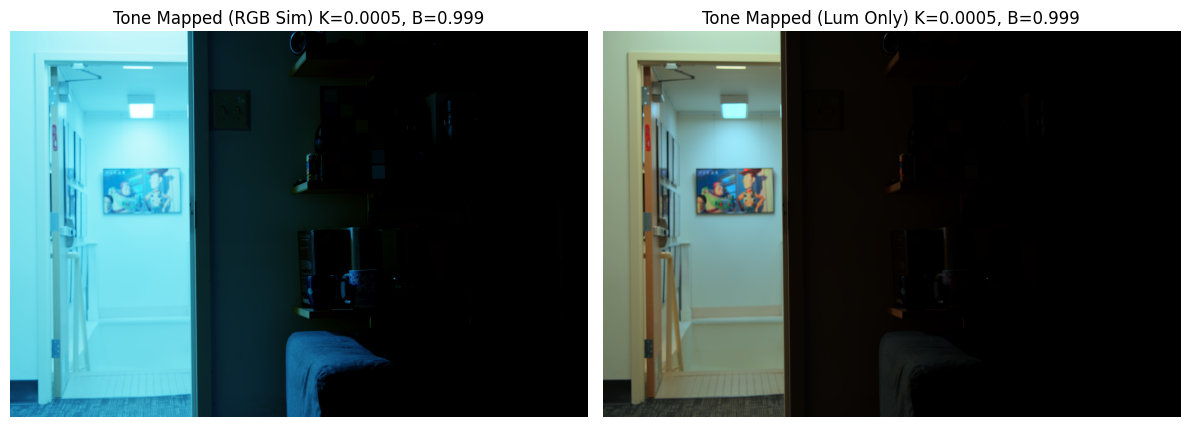


--- Tone Mapping Complete ---
Experiment with different K (key) and B (burn) values.
Compare the generated PNG files and discuss your results.


In [5]:
# --- Tone Mapping Configuration ---
# Load the color-corrected and white-balanced HDR image
corrected_hdr_path = "door_stack_corrected_wb.hdr" # From previous step
print(f"Loading corrected HDR image from: {corrected_hdr_path}")
hdr_corrected_bgr = cv2.imread(corrected_hdr_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
if hdr_corrected_bgr is None:
    raise FileNotFoundError(f"Could not load corrected HDR image: {corrected_hdr_path}")
hdr_corrected_rgb = hdr_corrected_bgr[:, :, ::-1].astype(np.float64) # Use float64

# Tone Mapping Parameters (Experiment with these!)
key_value = 0.0005 # K
burn_value = 0.999 # B
epsilon_value = 1e-8

# --- Apply Method 1: RGB Simultaneous ---
ldr_rgb_simultaneous = reinhard_tonemap_rgb(hdr_corrected_rgb, K=key_value, B=burn_value, epsilon=epsilon_value)
writeLDR(f"tm_rgb_K{key_value}_B{burn_value}.png", ldr_rgb_simultaneous)

# --- Apply Method 2: Luminance Only ---
# Check if conversion functions are available before trying
if 'lRGB2XYZ' in globals() and 'XYZ2lRGB' in globals():
     try:
        ldr_luminance_only = reinhard_tonemap_luminance(hdr_corrected_rgb, K=key_value, B=burn_value, epsilon=epsilon_value)
        writeLDR(f"tm_lum_K{key_value}_B{burn_value}.png", ldr_luminance_only)
     except NameError as e:
         print(f"Skipping Luminance method due to missing function: {e}")
     except Exception as e:
         print(f"An error occurred during Luminance method: {e}")
else:
     print("Skipping Luminance method because lRGB2XYZ or XYZ2lRGB is not available.")


# --- Display Results (Optional) ---
try:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(ldr_rgb_simultaneous) # LDR images are already 0-1, no gamma needed for direct display here if saved correctly
    plt.title(f"Tone Mapped (RGB Sim) K={key_value}, B={burn_value}")
    plt.axis('off')

    if 'ldr_luminance_only' in locals(): # Check if luminance method ran
        plt.subplot(1, 2, 2)
        plt.imshow(ldr_luminance_only)
        plt.title(f"Tone Mapped (Lum Only) K={key_value}, B={burn_value}")
        plt.axis('off')
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Luminance method skipped', horizontalalignment='center', verticalalignment='center')
        plt.axis('off')


    plt.tight_layout()
    comparison_tm_path = f"tm_comparison_K{key_value}_B{burn_value}.png"
    plt.savefig(comparison_tm_path)
    print(f"Saved tone mapping comparison plot to: {comparison_tm_path}")
    plt.show() # Might still fail if environment is non-interactive

except Exception as e:
    print(f"Could not generate tone mapping comparison plot: {e}")


print("\n--- Tone Mapping Complete ---")
print("Experiment with different K (key) and B (burn) values.")
print("Compare the generated PNG files and discuss your results.")
